<a href="https://colab.research.google.com/github/ua-datalab/MLWorkshops/blob/main/RNN/pytorch_char_rnn_classification_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

NLP From Scratch: Classifying Names with a Character-Level RNN
==============================================================

**Author**: [Sean Robertson](https://github.com/spro)

**Modified by**: Megh Krishnaswamy

This is a RNN tutorial released by the Pytorch team as part of their documentation, and is a fantastic example that demonstrates pre-processing data for NLP with basic python libraries, importing relevant Pytorch toolkits, and running the pipeline. Given the sophstication of transformer and convolution architecture, Recurrent
Neural Networks (RNNs)  are not used advanced NLP task at the word or sentence levels. However, there are many simple tasks that do not require the recource-heavy implementations that run current state-of-the-art systems. One such use-case is simple word classifications based on the characters they contain.

This notebook builds and trains a basic character-level Recurrent
Neural Network (RNN) to classify words by language.

A character-level RNN reads words as a series of characters -outputting
a prediction and \"hidden state\" at each step, feeding its previous
hidden state into each next step. We take the final prediction to be the
output, i.e. which class the word belongs to.

Specifically, we\'ll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

``` {.sourceCode .sh}
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```
This tutorial, along with two
other Natural Language Processing (NLP) \"from scratch\" tutorials, show how to preprocess data to model NLP. In particular
these tutorials do not use many of the convenience functions of
[torchtext]{.title-ref}, so you can see how preprocessing to model NLP works at a low level.

It would also be useful to know about RNNs and how they work:

-   [The Unreasonable Effectiveness of Recurrent Neural
    Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)
    shows a bunch of real life examples
- [Chapter 10. Sequence modeling: Recurrent and recursive nets](https://www.deeplearningbook.org/contents/rnn.html)- a general purpose textbook with engaging text
-   [Understanding LSTM
    Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
    is about LSTMs specifically but also informative about RNNs in
    general

The Data
------------------

This workshop needs a list of words from different languages. We will use 18 text files named as
`[Language].txt`. Each file contains a bunch of names, one name per
line. The names are mostly romanized, but we will need to deal with special diacritics in names by converting from Unicode to
ASCII.

The text files will be read into a dictionary, with the name of the langauge as key, and the words as a list it can call.
`{language: [names ...]}`. The generic variables \"category\" and
\"line\" (for language and name in our case) are used for later
extensibility.


In [ ]:
# Download and unzip the data (run once)
!wget  https://download.pytorch.org/tutorial/data.zip
!unzip data.zip


--2024-03-28 10:57:50--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.41.107, 18.160.41.124, 18.160.41.23, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.41.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.04s   

2024-03-28 10:57:50 (73.6 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Ita

In [ ]:
# import libraries
from io import open
import glob
import os
import unicodedata
import string


In [ ]:
# process filepath and extract filenames
def findFiles(path): return glob.glob(path)

for i in findFiles('data/names/*.txt'): print(i)

data/names/Irish.txt
data/names/Scottish.txt
data/names/Spanish.txt
data/names/Polish.txt
data/names/German.txt
data/names/English.txt
data/names/Korean.txt
data/names/Russian.txt
data/names/Arabic.txt
data/names/Czech.txt
data/names/Greek.txt
data/names/French.txt
data/names/Italian.txt
data/names/Dutch.txt
data/names/Portuguese.txt
data/names/Vietnamese.txt
data/names/Chinese.txt
data/names/Japanese.txt


In [ ]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [ ]:
# Build the a language-words dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file, split into lines, convert to ASCII
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [ ]:
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [ ]:
print(category_lines['Russian'])

['Ababko', 'Abaev', 'Abagyan', 'Abaidulin', 'Abaidullin', 'Abaimoff', 'Abaimov', 'Abakeliya', 'Abakovsky', 'Abakshin', 'Abakumoff', 'Abakumov', 'Abakumtsev', 'Abakushin', 'Abalakin', 'Abalakoff', 'Abalakov', 'Abaleshev', 'Abalihin', 'Abalikhin', 'Abalkin', 'Abalmasoff', 'Abalmasov', 'Abaloff', 'Abalov', 'Abamelek', 'Abanin', 'Abankin', 'Abarinoff', 'Abarinov', 'Abasheev', 'Abashev', 'Abashidze', 'Abashin', 'Abashkin', 'Abasov', 'Abatsiev', 'Abaturoff', 'Abaturov', 'Abaza', 'Abaziev', 'Abbakumov', 'Abbakumovsky', 'Abbasov', 'AbdankKossovsky', 'Abdeev', 'Abdildin', 'Abdrahimoff', 'Abdrahimov', 'Abdrahmanoff', 'Abdrahmanov', 'Abdrakhimoff', 'Abdrakhimov', 'Abdrakhmanoff', 'Abdrakhmanov', 'Abdrashitoff', 'Abdrashitov', 'Abdrazakoff', 'Abdrazakov', 'Abdulaev', 'Abdulatipoff', 'Abdulatipov', 'Abdulazizoff', 'Abdulazizov', 'Abdulbasiroff', 'Abdulbasirov', 'Abdulbekoff', 'Abdulbekov', 'Abdulgapuroff', 'Abdulgapurov', 'Abdulgaziev', 'Abdulhabiroff', 'Abdulhabirov', 'Abdulin', 'Abdulkadyroff', '

Now we have `category_lines`, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
`all_categories` (just a list of languages) and `n_categories` for later
reference.


In [ ]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


Turning Names into Tensors
==========================

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a \"one-hot vector\" of size
`<1 x n_letters>`. A one-hot vector is filled with 0s except for a 1 at
index of the current letter, e.g. `"b" = <0 1 0 0 0 ...>`.

To make a word we join a bunch of those into a 2D matrix
`<line_length x 1 x n_letters>`.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we\'re just using a batch size of 1 here.


In [ ]:
import torch

# Find letter index from list of all characters we created earlier (all_letters)
# e.g. "a" = 0, "b" = 1, and so on

def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('A'))

print(lineToTensor('Abandonato').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([10, 1, 57])


Creating the Network
====================

This RNN module (mostly copied from [the PyTorch for Torch users
tutorial \<https://pytorch.org/tutorials/beginner/former\_torchies/
nn\_tutorial.html\#example-2-recurrent-net\>]{.title-ref}\_\_) uses 2 linear layers, which operate on an input and hidden state. Thus, they provide us with the recurrent structure. After the output layer, we obtain a probability distribution to determine the liklihoods of a sequence belonging to different given classes using a `LogSoftmax` layer. The class with the highest probability is selected as the output.

In [ ]:
#import the Torch method for coding neural netowrks
import torch.nn as nn

#Create a class for structuring our RNN. Let's call it RNN
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# Use the class with the data we generated
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We\'ll get back the output (probability
of each language) and a next hidden state (which we keep for the next
step).


In [ ]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don\'t want to be creating a new Tensor
for every step, so we will use `lineToTensor` instead of
`letterToTensor` and use slices. This could be further optimized by
precomputing batches of Tensors.


In [ ]:
input = lineToTensor('Jones')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9225, -2.9846, -2.9840, -2.9728, -2.9074, -2.7994, -2.8317, -2.8092,
         -2.8417, -2.9928, -2.9278, -2.8261, -2.8820, -2.8347, -2.8935, -2.8395,
         -2.8917, -2.9196]], grad_fn=<LogSoftmaxBackward0>)


As you can see the output is a `<1 x n_categories>` Tensor, where every
item is the likelihood of that category (higher is more likely).


Training
========

Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. In this case, this the the frequency of a name belonging to a given language.

 We can use `Tensor.topk` to get the index
of the greatest value:


In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

#Print the category likely associated with 'Jones' (from the previous codebox)
print(categoryFromOutput(output))

('English', 5)


We will also want a quick way to get a training example (a name and its
language):


In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Japanese / line = Takei
category = English / line = East
category = Arabic / line = Sayegh
category = Greek / line = Pappayiorgas
category = Portuguese / line = Belo
category = Czech / line = Hrula
category = English / line = Monaghan
category = Vietnamese / line = Ton
category = Russian / line = Eimontov
category = Irish / line = Mckay


Training the Network
====================

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it\'s wrong.

For the loss function, the negative log likelihood loss `nn.NLLLoss` is appropriate, since the last layer of the RNN is `nn.LogSoftmax`. RNNs also work well with cross-entropy loss functions.

Read more about them here: [nn.NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html) and  [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)


In [ ]:
criterion = nn.NLLLoss()

Each loop of training will:

-   Create input and target tensors
-   Create a zeroed initial hidden state
-   Read each letter in and
    -   Keep hidden state for next letter
-   Compare final output to target
-   Back-propagate
-   Return the output and loss


In [ ]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the `train`
function returns both the output and loss we can print its guesses and
also keep track of loss for plotting. Since there are 1000s of examples
we print only every `print_every` examples, and take an average of the
loss.


In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()


In [ ]:
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 8s) 2.8938 Adam / Vietnamese ✗ (French)
10000 10% (0m 14s) 2.9475 Belmonte / Dutch ✗ (Spanish)
15000 15% (0m 21s) 0.3381 Paterson / Scottish ✓
20000 20% (0m 27s) 3.0618 Eustis / Greek ✗ (French)
25000 25% (0m 34s) 1.5609 Suess / Dutch ✗ (German)
30000 30% (0m 41s) 1.0346 Quraishi / Japanese ✗ (Arabic)
35000 35% (0m 47s) 0.8024 Si / Korean ✓
40000 40% (0m 53s) 0.2385 Kuroda / Japanese ✓
45000 45% (1m 1s) 1.0607 Aritza / Portuguese ✗ (Spanish)
50000 50% (1m 8s) 1.8155 Albrighton / Scottish ✗ (English)
55000 55% (1m 15s) 2.3010 Samios / Portuguese ✗ (Greek)
60000 60% (1m 21s) 0.0288 Czajkowski / Polish ✓
65000 65% (1m 28s) 0.8686 Tai / Vietnamese ✗ (Chinese)
70000 70% (1m 34s) 1.2490 Becker / German ✓
75000 75% (1m 41s) 2.6307 Kruckel / Czech ✗ (German)
80000 80% (1m 48s) 1.4150 O'Hara / Irish ✓
85000 85% (1m 54s) 0.4528 Sokoloff / Polish ✓
90000 90% (2m 1s) 1.6275 Lian / Vietnamese ✗ (Chinese)
95000 95% (2m 7s) 0.8568 Viteri / Italian ✓
100000 100% (2m 14s) 0.0479 Bajev / Rus

Plotting the Results
====================

Plotting the historical loss from `all_losses` shows the network learning. The loss captures the error of the model. If the loss value is going down, then the distance between the real and predicted values is decreasing, and we say that the model is learning.


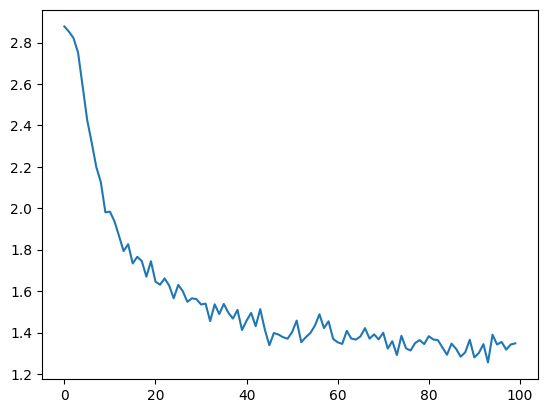

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with `evaluate()`,
which is the same as `train()` minus the backprop.


In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output


In [ ]:
# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()


<ipython-input-38-077bea1f1a1d>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-38-077bea1f1a1d>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


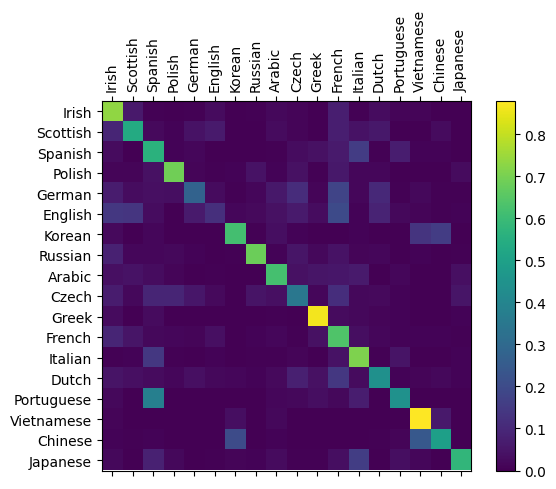

In [ ]:
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).


Running on User Input
=====================


In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])



> Dovesky
(-0.62) Russian
(-1.53) Czech
(-2.04) Irish

> Jackson
(-0.21) Scottish
(-2.47) English
(-3.31) Dutch

> Satoshi
(-0.67) Italian
(-2.11) Arabic
(-2.40) Japanese


In [ ]:

predict('Dovesky')
predict('Jackson')
predict('Satoshi')

Exercises
=========

-   Try with a different dataset of line -\> category, for example:
    -   Any word -\> language
    -   First name -\> gender
    -   Character name -\> writer
    -   Page title -\> blog or subreddit
